In [15]:
import cfbd
import pandas as pd
import matplotlib.pyplot as plt

# Configuration
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'JOo7NPQiRwoWx1kDmv1VDiujh+ra/nfYLRGy0TVt2KhLM+Yiu6BpXOC7W4YtjBdq'
configuration.api_key_prefix['Authorization'] = 'Bearer'

# Initialize APIs
teams_api = cfbd.TeamsApi(cfbd.ApiClient(configuration))
players_api = cfbd.PlayersApi(cfbd.ApiClient(configuration))

# Define conferences
conferences = ['SEC', 'B10', 'B12']

# Get team information
teams = [team for conf in conferences for team in teams_api.get_teams(conference=conf)]
team_info = pd.DataFrame.from_records([t.to_dict() for t in teams])[['school', 'color', 'conference']].rename(columns={'school': 'team'})

# Filter team_info for the desired conferences
team_info = team_info[team_info['conference'].isin(conferences)]

# Get player season stats for each conference and concatenate the results
player_season_stats = []
for conference in conferences:
    conference_stats = players_api.get_player_season_stats(year=2022, conference=conference)
    player_season_stats.extend(conference_stats)

# Processing
player_stats_df = pd.DataFrame.from_records([p.to_dict() for p in player_season_stats])

In [19]:
player_stats_df

,season,player_id,player,team,conference,category,stat_type,stat
9,None,4431051,Izayah Cummings,Kentucky,SEC,rushing,YDS,23.0
25,None,4712579,Dillon Bell,Georgia,SEC,receiving,YDS,180.0
37,None,5081405,AJ Swann,Vanderbilt,SEC,rushing,YDS,-76.0
61,None,4429160,Devon Achane,Texas A&M,SEC,rushing,YDS,1102.0
104,None,4362620,Kavosiey Smoke,Kentucky,SEC,receiving,YDS,30.0
...,...,...,...,...,...,...,...,...
15093,None,4590302,Deon Silas,Iowa State,Big 12,receiving,YDS,38.0
15103,None,4565193,Aidan Bitter,Iowa State,Big 12,receiving,YDS,26.0
15104,None,4373016,Josh Fleeks,Baylor,Big 12,receiving,YDS,49.0
15123,None,4360900,Jason Bean,Kansas,Big 12,rushing,YDS,222.0


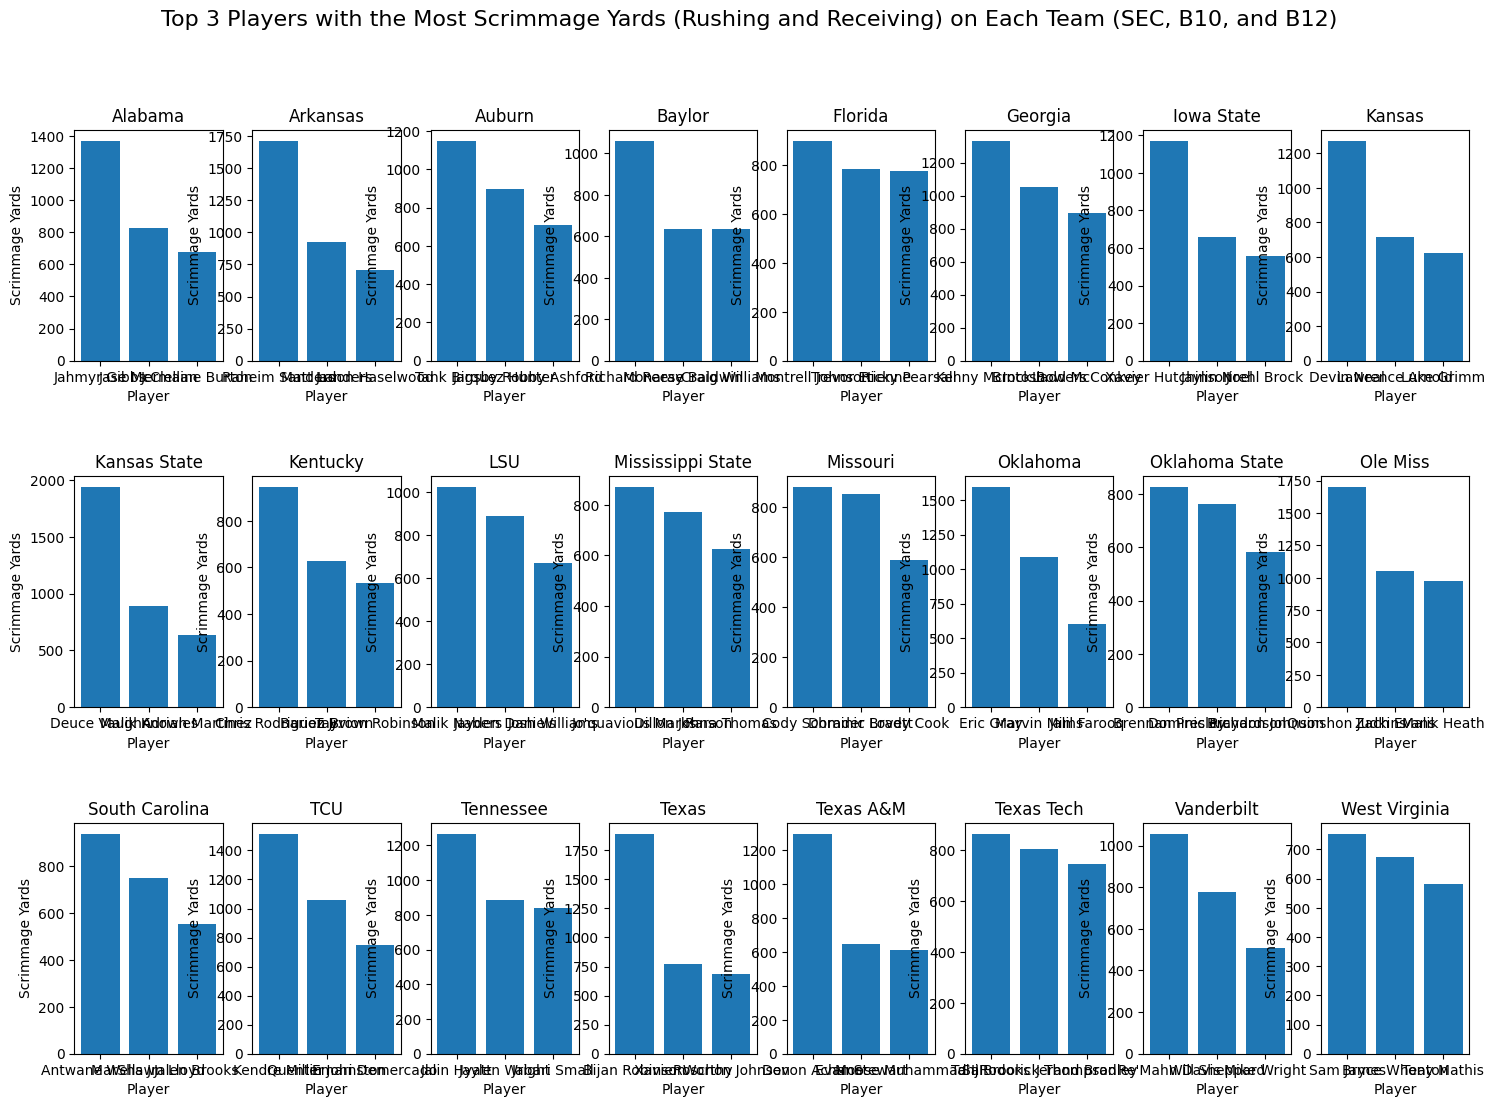

In [25]:
# Filter for rushing and receiving categories with stat_type YDS
player_stats_df = player_stats_df[(player_stats_df['category'].isin(['rushing', 'receiving'])) & (player_stats_df['stat_type'] == 'YDS')]

# Pivot the player_stats_df DataFrame to get scrimmage_yds
player_stats_pivot = player_stats_df.pivot_table(index=['team', 'player'], columns='category', values='stat').reset_index()
player_stats_pivot['scrimmage_yds'] = player_stats_pivot['rushing'].fillna(0) + player_stats_pivot['receiving'].fillna(0)

# Merge team_info with player_stats_pivot
merged_df = pd.merge(player_stats_pivot, team_info, on='team', how='left')

# Group by team and sort players by scrimmage_yds, then take the top 3 players per team
top_players_by_team = merged_df.groupby('team').apply(lambda x: x.nlargest(3, 'scrimmage_yds')).reset_index(drop=True)

# Plot bar charts for each team
unique_teams = top_players_by_team['team'].unique()
num_teams = len(unique_teams)
fig, axes = plt.subplots(nrows=3, ncols=num_teams//3, figsize=(18, 12))
plt.subplots_adjust(hspace=0.5)

for i, team in enumerate(unique_teams):
    team_data = top_players_by_team[top_players_by_team['team'] == team]
    ax = axes[i // (num_teams // 3), i % (num_teams // 3)]
    ax.bar(team_data['player'], team_data['scrimmage_yds'])
    ax.set_title(team)
    ax.set_xlabel('Player')
    ax.set_ylabel('Scrimmage Yards')

plt.suptitle('Top 3 Players with the Most Scrimmage Yards (Rushing and Receiving) on Each Team (SEC, B10, and B12)', fontsize=16)
plt.show()
